# Data Cleansing and Feature Extraction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
%xmode Minimal

Exception reporting mode: Minimal


In [23]:
DATASET_COLUMNS = ['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df['target'] = (df['target'] == 4).astype(int)
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Initial Data Exploration

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Class balance - Too good to be true...

In [25]:
df_counts = df['target'].value_counts()
df_counts

target
0    800000
1    800000
Name: count, dtype: int64

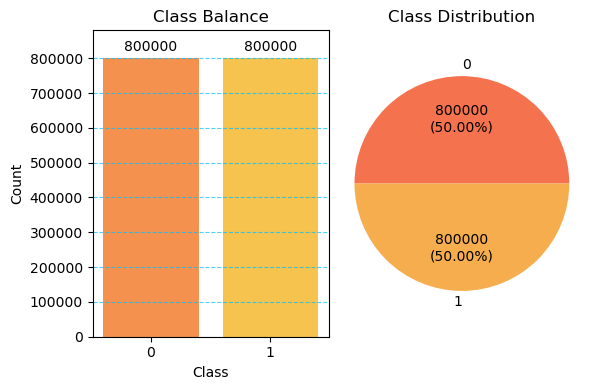

In [26]:
def ceil_thousand(num):
    ceil = math.ceil((num - 1000) / 1000) * 1000
    return ceil

def simple_bar(counts, ax):
    bars = ax.bar(counts.index.astype(str), counts.values, color=['#F5914E', '#F5C34E'])
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.margins(0.05, 0.1)
    ax.set_title('Class Balance')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7, color='deepskyblue')

def simple_pie(counts, ax):
    ax.pie(counts, labels=counts.index, colors = ['#F5724E', '#F5AD4E'],
           autopct=lambda p: '{:.0f}\n({:.2f}%)'.format(p * sum(counts) / 100, p))
    ax.axis('equal')
    ax.set_title('Class Distribution')

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

simple_bar(df_counts, axs[0])
simple_pie(df_counts, axs[1])

plt.tight_layout()
plt.show()



In [13]:
sample_size = 500000
data = df[['text', 'target']].sample(n=sample_size, random_state=43).reset_index(drop=True)


In [14]:
data_counts = data['target'].value_counts()
print(data_counts)
data

target
0    250132
1    249868
Name: count, dtype: int64


,text,target
0,@speakforme I know. We should go asap. like wh...,0
1,@pcdmelodyt hi melody @AshleyLTMSYF hi ashley...,1
2,Mount Larcom (finally,1
3,@Lisa_Nova we had it but we lost it very sad ...,0
4,@kneath I hate you so much right now,1
...,...,...
499995,I hate having weak jaws! http://bit.ly/fuE6t,0
499996,Yay at new phone apps for twitter,1
499997,@rustyrockets &quot;some say he had phone sex ...,1
499998,"I jumped the gun and ate my yogurt too soon, n...",0


In [17]:
def bar_difference(counts, ax):
    bars = ax.bar(counts.index.astype(str), counts.values, color=['#F5D64E', '#F5D09F'])
    
    n = min(counts.values[0], counts.values[1])
    m = max(counts.values[0], counts.values[1])
    diff = m-n
    # Adjust the ylim to include some space above the max value to show the difference
    ax.set_ylim(top=(m + diff / 4), bottom=(n - diff / 4))

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    diff_annotation = f'Difference: {diff}'
    ax.text(0.5, m + diff / 8, diff_annotation, ha='center', va='bottom', fontsize=9, color='red')


    ax.set_title(f"Balance Comparison (y starting at {ceil_thousand(n)})")
    ax.set_ylabel('Count')
    ax.set_xlabel('Class')

    ax.axhline(y=min(n, m), color='red', linewidth=1.5, linestyle='--')

    

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

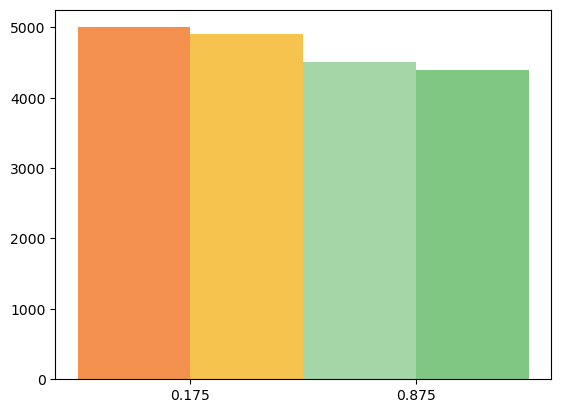

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def simple_bar(original_counts, new_counts):
    # Setup the figure and axes
    fig, ax = plt.subplots()

    # Set the width of the bars
    bar_width = 0.35

    # Calculate the positions for the original and new bars
    indices = np.arange(len(original_counts))
    original_positions = indices * 2 * bar_width
    new_positions = original_positions + bar_width

    # Plot bars for original and new counts
    original_bars = ax.bar(original_positions, original_counts.values, bar_width, label='Original', color=['#F5914E', '#A5D6A7'])
    new_bars = ax.bar(new_positions, new_counts.values, bar_width, label='Reduced', color=['#F5C34E', '#81C784'])

    # Set the x-ticks and x-tick labels
    ax.set_xticks(new_positions - bar_width / 2)
    ax.set_xticklabels(['Class 0', 'Class 1'] * len(original_counts))

    # Annotate bars with height labels
    for bars in [original_bars, new_bars]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Create custom legend
    legend_handles = [mpatches.Patch(color='#F5914E', label='Original Class 0'),
                      mpatches.Patch(color='#A5D6A7', label='Original Class 1'),
                      mpatches.Patch(color='#F5C34E', label='Reduced Class 0'),
                      mpatches.Patch(color='#81C784', label='Reduced Class 1')]
    ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Set chart title and labels
    ax.set_title('Class Balance Before and After Reduction')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Class')

    plt.tight_layout()
    plt.show()

# Example data
original_counts = pd.Series([5000, 4500], index=['Class 0', 'Class 1'])
new_counts = pd.Series([4900, 4400], index=['Class 0', 'Class 1'])

simple_bar(original_counts, new_counts)


In [60]:
def compare_bar(original_counts, new_counts, ax):
    # Indices for the groups
    index = np.arange(2)
    bar_width = 0.2

    original_bar = ax.bar(index, original_counts.values, bar_width, label='Original', color=['#F5914E', '#A5D6A7'])
    new_bar = ax.bar(index + bar_width, new_counts.values, bar_width, label='Reduced', color=['#F5C34E', '#81C784'])

    ax.set_xlabel('Class')
    ax.set_ylabel('Counts')
    ax.set_title('Class Balance Before and After Reduction')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['Class 0', 'Class 1'])

    # Annotate bars with height labels
    for bars in (original_bar, new_bar):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    # Create custom legend
    legend_handles = [mpatches.Patch(color='#F5914E', label='Original Class 0'),
                      mpatches.Patch(color='#F5C34E', label='Reduced Class 0'),
                      mpatches.Patch(color='#A5D6A7', label='Original Class 1'),
                      mpatches.Patch(color='#81C784', label='Reduced Class 1')]

    # Place the legend at the bottom
    ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    ax.margins(0.05, 0.1)
    plt.tight_layout()
    plt.show()

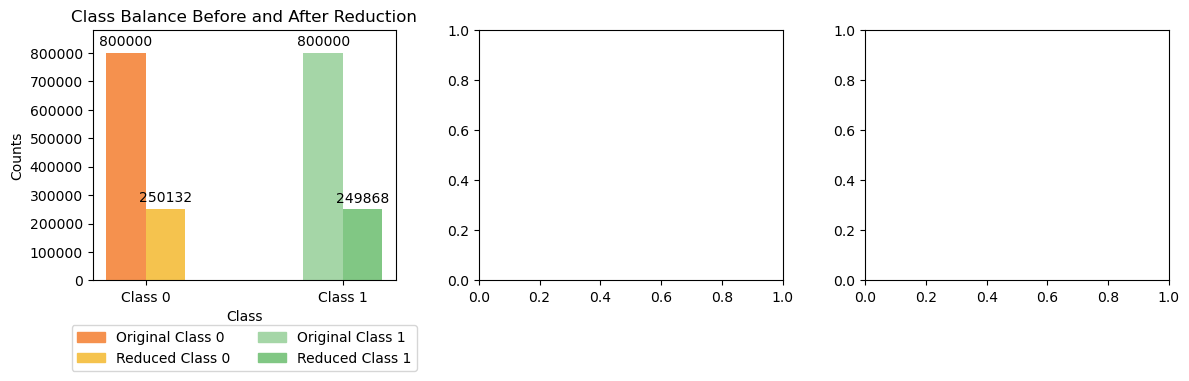

<Figure size 640x480 with 0 Axes>

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

compare_bar(df_counts,data_counts, axs[0])
bar_difference(data_counts, axs[1])
simple_pie( data_counts, axs[2])

plt.tight_layout()
plt.show()

In many real-world applications, datasets are inherently imbalanced, meaning that the classes of interest are not equally represented. For instance, in fraud detection, fraudulent transactions are typically much less frequent than legitimate ones. Similarly, in medical diagnosis, instances of a particular disease may be rare compared to the healthy population. This imbalance poses a challenge for machine learning models, as they may become biased towards the majority class, resulting in poor performance on the minority class, which is often of greater interest.

To address these challenges and develop solutions that are robust in the face of class imbalance, it is crucial for data scientists and machine learning practitioners to understand how models perform under such conditions. By intentionally introducing class imbalance into our project's dataset, we aim to simulate real-world conditions more closely. This allows us to explore and evaluate strategies for handling imbalanced data, such as resampling techniques, cost-sensitive learning, or the use of specific evaluation metrics that are more informative for imbalanced datasets.

This approach not only enhances the realism of our project but also prepares us to tackle similar challenges in real-world applications. It underscores the importance of careful preprocessing, model selection, and evaluation strategies that account for class imbalance. Through this process, we seek to contribute insights and methodologies that are directly applicable to practical problems, ultimately leading to more effective and equitable machine learning solutions.

In [20]:
import pandas as pd
import numpy as np

# Set the seed for random number generation
np.random.seed(42)

# Define the ranges for x and y
n = data['target'].value_counts()[0]  # Upper limit for class 0
m = data['target'].value_counts()[1]  # Upper limit for class 1

# Generate random numbers x and y
x = np.random.randint(sample_size/4, n + 1)
y = np.random.randint(sample_size/4, m + 1)

print(f"Number of entries to keep from Class 0: {x}")
print(f"Number of entries to keep from Class 1: {y}")

reduced_data_class_1 = data[data['target']==0].sample(n=x, random_state=43)
reduced_data_class_0 = data[data['target']==1].sample(n=y, random_state=43)

reduced_data = pd.concat([reduced_data_class_0, reduced_data_class_1], ignore_index=True)

print(f"Original data size: {len(data)}, Reduced data size: {len(reduced_data)}")
reduced_data

Number of entries to keep from Class 0: 246958
Number of entries to keep from Class 1: 140795
Original data size: 500000, Reduced data size: 387753


,text,target
0,yesterday was such a nice day...why does it ne...,1
1,Listening to @supertodda iTunes library... Pin...,1
2,Im going to bed I hope I get a call in the mor...,1
3,@taiforever done geo finally. now i have a han...,1
4,@misslazarou @LiaWhiting sai uma dose de sardi...,1
...,...,...
387748,is having issues breathing this morning! It hu...,0
387749,would kill for a lie in,0
387750,A few more hrs with the visitin fam,0
387751,@phoenixpwns That's true but still,0


In [21]:
reduced_data_counts = reduced_data['target'].value_counts()
reduced_data_counts

target
0    246958
1    140795
Name: count, dtype: int64

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

simple_bar(reduced_data_counts, axs[0])
simple_pie(reduced_data_counts, axs[2])
bar_difference(reduced_data_counts, axs[1])

plt.tight_layout()
plt.show()

## Data Pre-processing

In [ ]:
import re, string, contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import re
import  string

# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

### Noise removal and Tokenization

In [ ]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
import contractions
import re

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

def preprocess_text(text):
    # Step 1: Expand contractions
    text = contractions.fix(text)
    
   # Step 2: Remove URLs starting with http or https
    text = re.sub(r'http[s]?://[^\s]+', '', text)
    
    # Step 3: Remove URLs with common top-level domains (TLDs)
    text = re.sub(r'(?:www\.)?[a-zA-Z0-9-]+\.(com|org|net|edu|gov|io)[^\s]*', '', text)
    
    # Step 4: Remove www. prefixes not covered by previous steps
    text = re.sub(r'www\.[a-zA-Z0-9-]+\.[^\s]+', '', text)
    
    # Step 5: Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # Step 6: Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Step 7: Remove non-ASCII characters
    text = ''.join(i for i in text if ord(i) < 128)
    
    # Step 8: Tokenize
    tokens = tokenizer.tokenize(text)
    
    return tokens

# Apply the enhanced preprocessing function to each text entry in the DataFrame
reduced_data['text'] = reduced_data['text'].apply(preprocess_text)

In [ ]:
print(reduced_data['text'][0])
reduced_data

### Lemmatization and Case Lowering

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_and_lower(tokens):
    cleaned_tokens = []
    for token, tag in pos_tag(tokens):
        if tag.startswith("NN"):
            pos = 'n'
        
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        token = lemmatizer.lemmatize(token,pos)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stopwords.words('english'):
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

reduced_data.loc[:,'text'] = reduced_data.loc[:,'text'].apply(lambda x: lemmatize_and_lower(x))

In [ ]:
print(reduced_data['text'][0])

In [ ]:
reduced_data.to_csv('tokenized.csv', index=False)

In [ ]:
print(reduced_data['text'])

## Feature Engineering

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import ast
import nltk
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('wordnet')
# nltk.download('stopwords')

### Tf-Idf Vectorization

In [ ]:
tokenized = pd.read_csv('tokenized.csv')

In [ ]:
tokenized

In [ ]:
from collections import Counter

# Flatten the list of lists into a single list of tokens
all_tokens = []

for token_string in tokenized['text']:
    tokens = ast.literal_eval(token_string)
    for token in tokens:
        all_tokens.append(token)

all_tokens

In [ ]:
# Calculate the frequencies of each token
token_frequencies = Counter(all_tokens)

# Create a DataFrame from the token frequencies
word_freq_df = pd.DataFrame(token_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)

word_freq_df

In [ ]:
import matplotlib.pyplot as plt

# Visualize the top 20 most common words
top_n = 20
plt.figure(figsize=(10, 8))
plt.bar(word_freq_df['Word'][:top_n], word_freq_df['Frequency'][:top_n], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} Most Common Words')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming word_freq_df is your DataFrame with the word frequencies

# Histogram of word frequencies
plt.figure(figsize=(10, 6))
plt.hist(word_freq_df['Frequency'], bins=50, color='skyblue', edgecolor='black')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.yscale('log')  # Use log scale for better visibility of lower frequencies
plt.show()

# Log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(word_freq_df) + 1), word_freq_df['Frequency'].sort_values(ascending=False), marker='o', linestyle='-', color='skyblue')
plt.title('Word Frequency Distribution (Log-Log Scale)')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))
data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000,
                             max_df=0.01, 
                             min_df=20, 
                             ngram_range=(1,2))

tfidf_matrix = vectorizer.fit_transform(data['text'])

In [ ]:
feature_names = vectorizer.get_feature_names_out()
tfidf_pd = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [ ]:
tfidf_pd

In [ ]:
tfidf_pd.to_csv('tfidf_pd.csv')

### SVDTransformer for dimentionality reduction

In [ ]:
tfidf_pd = pd.read_csv('tfidf_pd.csv')

In [ ]:
from sklearn import decomposition

svd = decomposition.TruncatedSVD(n_components=200)
svd_df = svd.fit_transform(tfidf_pd)

In [ ]:
svd_df_pd = pd.DataFrame(svd_df, columns=[f'PC{i+1}' for i in range(svd_df.shape[1])])
svd_df_pd

In [ ]:
svd_df_pd.columns

In [ ]:
svd_df_pd.to_csv('svd_df.csv')